In [41]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
sys.path.append('..')

import utilities.functions as functions


from utilities.functions import (
    summary,
    matriz_migracao,
    save_parquet,
    gerar_resumo_decis,
    resumo_coorte_ativa,
    cria_base_decil_wide

)

In [42]:
df_pub_u = pd.read_parquet("dados/gold/df_pub_un.parquet")

Sumarizacao na visao cliente - mes

In [43]:
summary(df_pub_u)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,33,18,00010814ab1e602ccbc9ffe3b64f44973491b2fd6d8ab7...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
origin_platform,33,3,ANDROID,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_target,33,2,target,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_created_month,33.0,NaN,NaN,NaN,5.333333,5.458174,1.0,1.0,1.0,12.0,12.0
num_pedidos_mes,33.0,NaN,NaN,NaN,4.181818,5.581524,1.0,1.0,2.0,4.0,23.0
num_pedidos_hist,33.0,NaN,NaN,NaN,8.030303,10.242329,1.0,2.0,4.0,9.0,34.0
total_amount_mes,33.0,NaN,NaN,NaN,191.515152,252.620715,17.9,62.9,100.0,187.0,1011.36
ticket_medio,33.0,NaN,NaN,NaN,48.906579,23.822922,16.725,34.125,43.972174,57.0,106.62


Clientes mes x target

In [44]:
clientes_mes = (df_pub_u.groupby(['order_created_month', 'is_target'])
              ['customer_id']
              .nunique()
              .reset_index(name='numero_clientes_distintos'))
clientes_mes

,order_created_month,is_target,numero_clientes_distintos
0,1,control,7
1,1,target,11
2,12,control,5
3,12,target,6


 Matriz de migracao - cliente

In [45]:
matriz_migracao(df_pub_u,mes_0=12,mes_1=1)

,mes_12,mes_1,is_target,total_clientes
0,0,1,control,2
1,0,1,target,5
2,1,1,control,5
3,1,1,target,6


Dado o montante de clientes novos em janeiro a analise sera feita basead em cliente ambos os meses e cliente somente em janeiro

In [46]:
id_both_monht=df_pub_u[df_pub_u['order_created_month']==12]['customer_id'].unique()
publico_janeiro_dezembro = df_pub_u[df_pub_u['customer_id'].isin(id_both_monht)].reset_index(drop=True)
publico_janeiro = df_pub_u[~df_pub_u['customer_id'].isin(id_both_monht)].reset_index(drop=True)

In [47]:
publico_janeiro.head()

,customer_id,origin_platform,is_target,order_created_month,num_pedidos_mes,num_pedidos_hist,total_amount_mes,ticket_medio
0,000182788d43dc500c94ce7dfb6809b84f8561860efc53...,IOS,target,1,1,1,24.80,24.80
1,00016cfde8c0af0a4a3c6c31956cd0c5e3ef230054183e...,DESKTOP,control,1,1,1,51.98,51.98
2,0001484091f67071593b292cc04917bd6f4fc61c8de826...,IOS,control,1,1,1,43.70,43.70
3,0001274ea3bc24cee339c5bfe5c579c9175cb9a3a50503...,ANDROID,target,1,1,1,62.90,62.90
4,0001004b6873a53fef60d11f4d2e4435ea27bed7e5fc38...,IOS,target,1,1,1,30.90,30.90


In [48]:
save_parquet(publico_janeiro_dezembro, "gold", "publico_janeiro_dezembro.parquet")


💾 SALVO: dados/gold/publico_janeiro_dezembro.parquet
📁 Local: /Users/maceli/ifood_case/code/notebook/dados/gold/publico_janeiro_dezembro.parquet


PosixPath('dados/gold/publico_janeiro_dezembro.parquet')

Pedidos por mes - target

In [49]:
pedidos_total = (
    publico_janeiro_dezembro.groupby(['is_target','order_created_month'])['num_pedidos_mes']
      .sum()
      .reset_index(name='numero_de_pedidos_total')
)

pedidos_total

,is_target,order_created_month,numero_de_pedidos_total
0,control,1,61
1,control,12,31
2,target,1,22
3,target,12,13


Distruibuicao do total amount por mes

In [50]:
df_stats_mes = publico_janeiro_dezembro.groupby(['order_created_month', 'is_target'])['total_amount_mes'].agg(
    Média=('mean'),
    Mediana=('median'),
    Mínimo=('min'),
    Máximo=('max'),
    Desvio_Padrão=('std')
).round(2)
df_stats_mes

Média  Mediana  Mínimo   Máximo  Desvio_Padrão
order_created_month is_target                                                 
1                   control    400.10   188.19    88.8  1011.36         422.09
                    target     111.51   110.80    17.9   187.00          65.38
12                  control    237.44   114.00    88.8   528.56         201.41
                    target      67.12    67.78    17.9   119.90          35.14

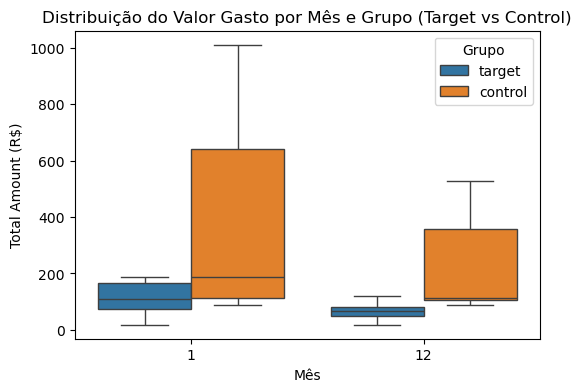

In [51]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=publico_janeiro_dezembro,
    y='total_amount_mes',
    x='order_created_month',  
    hue='is_target',          
    
)

plt.title('Distribuição do Valor Gasto por Mês e Grupo (Target vs Control)')
plt.ylabel('Total Amount (R$)')
plt.xlabel('Mês')
plt.legend(title='Grupo')
plt.show()

Observa-se grande numero de outliers, verificar a distribuicao removendo outliers.

In [52]:
publico_janeiro_dezembro['total_amount_mes'].describe().round(2)


count      26.00
mean      212.87
std       266.73
min        17.90
25%        86.50
50%       114.00
75%       187.89
max      1011.36
Name: total_amount_mes, dtype: float64

<Axes: >

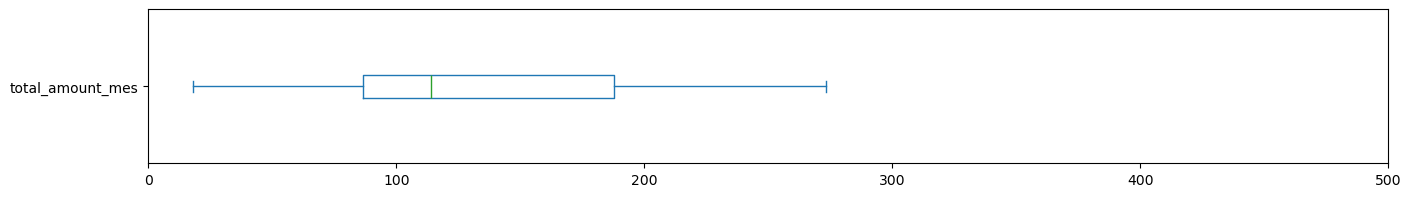

In [53]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
publico_janeiro_dezembro['total_amount_mes'].plot(kind='box', xlim=(0, 500), vert=False, flierprops=red_square, figsize=(16,2))

In [54]:
distance = 1.5 * (np.nanpercentile(publico_janeiro_dezembro['total_amount_mes'], 75) - np.nanpercentile(publico_janeiro_dezembro['total_amount_mes'], 25))
lim_sup=distance + np.nanpercentile(publico_janeiro_dezembro['total_amount_mes'], 75)

In [55]:
pb_drop = publico_janeiro_dezembro.drop(
    publico_janeiro_dezembro[
        (publico_janeiro_dezembro['total_amount_mes'] == 0) |
        (publico_janeiro_dezembro['total_amount_mes'] > lim_sup)
    ].index,
    axis=0
)

In [56]:
pb_drop['total_amount_mes'].describe().round(2)

count     22.00
mean     111.58
std       61.10
min       17.90
25%       73.11
50%      107.00
75%      131.30
max      273.00
Name: total_amount_mes, dtype: float64

<Axes: >

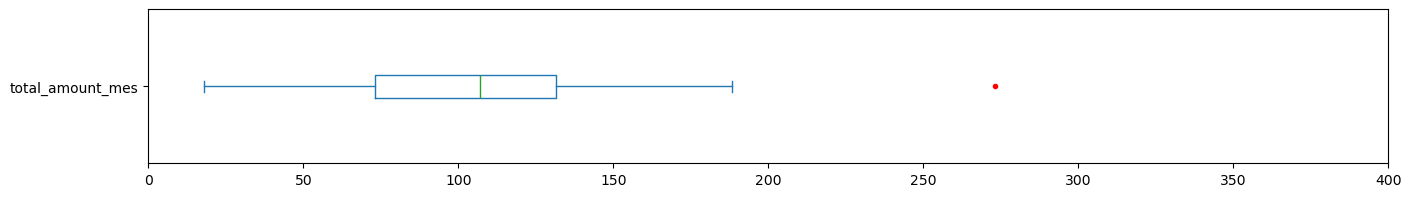

In [57]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
pb_drop['total_amount_mes'].plot(kind='box', xlim=(0, 400), vert=False, flierprops=red_square, figsize=(16,2))

In [58]:
df_decil,decil_dict=cria_base_decil_wide(publico_janeiro_dezembro,
    mes_0=12,  
    mes_1=1,  
    col_cliente="customer_id",
    col_mes="order_created_month",
    col_pedidos="num_pedidos_mes",
    col_valor="total_amount_mes",
    col_target="is_target",  
    n_decis=10,
    prefixo_decil="decil",
    prefixo_pedidos="num_pedidos_mes",
    prefixo_valor="total_amount_mes"
)

/Users/maceli/ifood_case/code/notebook/../utilities/functions.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_m0.groupby(col_decil_m0)[col_valor]


In [59]:
df_decil['decil_1'].unique()

array(['decil 9', 'decil 8', 'decil 3', 'decil 5', 'decil 7', 'decil 4',
       'decil 1'], dtype=object)

In [60]:
save_parquet(df_decil, "gold", "df_decil.parquet")

💾 SALVO: dados/gold/df_decil.parquet
📁 Local: /Users/maceli/ifood_case/code/notebook/dados/gold/df_decil.parquet


PosixPath('dados/gold/df_decil.parquet')

In [61]:
#import os
#os.makedirs('../dados/gold', exist_ok=True)

decil_dict_json = {k: list(v) for k, v in decil_dict.items()}
with open('dados/gold/decil_dictionary.json', 'w') as f:
    json.dump(decil_dict_json, f, indent=2)

In [62]:
decil_summary=gerar_resumo_decis(df_decil)
decil_summary

,decil_12,decil_1,is_target,total_clientes,avg_amount_12,avg_amount_1,avg_pedidos_12,avg_pedidos_1,ticket_medio_12,ticket_medio_1
0,decil 1,decil 1,target,1,17.90,17.90,1.0,1.0,17.90,17.90
1,decil 1,decil 8,target,1,42.90,187.00,2.0,7.0,21.45,26.71
2,decil 10,decil 9,control,1,528.56,1011.36,11.0,23.0,48.05,43.97
3,decil 2,decil 8,target,1,66.90,135.10,4.0,7.0,16.73,19.30
4,decil 3,decil 3,target,1,68.65,68.65,2.0,2.0,34.33,34.33
5,decil 4,decil 4,target,1,86.50,86.50,2.0,2.0,43.25,43.25
6,decil 5,decil 5,control,1,88.80,88.80,1.0,1.0,88.80,88.80
7,decil 6,decil 9,control,1,100.00,273.00,2.0,8.0,50.00,34.12
8,decil 7,decil 7,control,1,114.00,114.00,2.0,2.0,57.00,57.00
9,decil 8,decil 8,target,1,119.90,173.90,2.0,3.0,59.95,57.97


In [63]:
os.makedirs('../Resultados', exist_ok=True)

decil_summary.to_csv('../Resultados/decil_summary.csv', index=False)



Numero de pedidos em Janeiro e Dezembro para o quem esteve em ambos meses

In [64]:

pedidos_hist=resumo_coorte_ativa(publico_janeiro_dezembro,mes_coorte_inicio=12,mes_coorte_fim=1)
pedidos_hist

,is_target,Total_Pedidos_Mes_1,Total_Pedidos_Mes_12,Total_Clientes
0,control,1,1,1
1,control,2,2,1
2,control,4,4,1
3,control,8,2,1
4,control,46,22,1
5,target,1,1,1
6,target,2,2,2
7,target,3,2,1
8,target,7,2,1
9,target,7,4,1


In [65]:
pedidos_hist.to_csv('../Resultados/pedidos_hist.csv', index=False)